# 3-and-out rates

In [194]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob

from scipy.interpolate import make_interp_spline, BSpline

sns.set(style="whitegrid", 
        palette="pastel", 
        font='Circular Spotify Text', 
        font_scale = 1.1, 
        rc= {'grid.color': '.95', 'xtick.color': '.3', 'ytick.color': '.3'})


## Data

In [195]:
#df = pd.read_csv("../data/reg_pbp_2018.csv")

df = pd.concat(map(pd.read_csv, glob.glob('../data/*.csv')))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [196]:
df.head()

,air_epa,air_wpa,air_yards,assist_tackle,assist_tackle_1_player_id,assist_tackle_1_player_name,assist_tackle_1_team,assist_tackle_2_player_id,assist_tackle_2_player_name,assist_tackle_2_team,...,wp,wpa,yac_epa,yac_wpa,yardline_100,yards_after_catch,yards_gained,ydsnet,ydstogo,yrdln
0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,35.0,NaN,0.0,73,0,PHI 35
1,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.500007,-0.021016,NaN,NaN,75.0,NaN,0.0,73,10,ATL 25
2,0.042241,0.001562,8.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.478991,0.026109,0.776103,0.024547,80.0,2.0,10.0,73,15,ATL 20
3,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.505100,0.043277,NaN,NaN,70.0,NaN,11.0,73,5,ATL 30
4,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.548377,0.045614,NaN,NaN,59.0,NaN,20.0,73,10,ATL 41


In [197]:
df['converted'] = (df['yards_gained'] >= df['ydstogo']) & (df['yards_gained'] > 0) & (np.isnan(df['down']) == False)
df['victory_formation'] = (df['qb_kneel'] == 1) & (df['quarter_end'].shift(-1) == 1)
df['drive_id'] = df['game_id'].map(str) + '-' +  df['drive'].map(str)

In [198]:
# Determining the drive team. First team to play on the drive id.
# Extract drive_ids and their minimum play number, then join back in the team into the main dataframe?

drive_teams = df.sort_values(['game_id', 'play_id'], ascending=True).groupby('drive_id')['posteam'].first().reset_index()
drive_teams = drive_teams.rename(columns={"posteam": "drive_team"})
df = pd.merge(df, drive_teams, how='left')

In [199]:
df['scoring_drive'] = (df['drive_team'] == df['posteam']) & (df['sp'] == 1)
df['fg_attempt'] = (df['play_type'] == 'field_goal') & (df['sp'] == 0)

In [200]:
drives = df.groupby(['game_id', 'drive_team', 'drive_id'])['converted', 'victory_formation', 'scoring_drive', 'fg_attempt'].max().reset_index()
drives['three_and_out'] = (
    (drives['converted'] == False) & 
    (drives['victory_formation'] == False) & 
    (drives['scoring_drive'] == False) &
    (drives['fg_attempt'] == False)
)

In [201]:
drives.groupby('drive_team')['three_and_out'].mean().reset_index().sort_values('three_and_out', ascending=True)

,drive_team,three_and_out
18,LAC,0.225627
22,NO,0.242778
8,DAL,0.244693
1,ATL,0.244898
21,NE,0.246494
27,PIT,0.263760
11,GB,0.264562
26,PHI,0.271465
20,MIN,0.279530
17,LA,0.279588


In [202]:
drives[drives['drive_team'] == 'LA']

,game_id,drive_team,drive_id,converted,victory_formation,scoring_drive,fg_attempt,three_and_out
42674,2016091201,LA,2016091201-1,True,False,False,False,False
42675,2016091201,LA,2016091201-11,False,False,False,False,True
42676,2016091201,LA,2016091201-13,False,False,False,False,True
42677,2016091201,LA,2016091201-16,False,False,False,False,True
42678,2016091201,LA,2016091201-18,False,False,False,False,True
42679,2016091201,LA,2016091201-20,True,False,False,False,False
42680,2016091201,LA,2016091201-22,True,False,False,False,False
42681,2016091201,LA,2016091201-24,False,False,False,False,True
42682,2016091201,LA,2016091201-26,True,False,False,False,False
42683,2016091201,LA,2016091201-28,False,True,False,False,False


In [203]:
games = drives.groupby(['game_id', 'drive_team'])['three_and_out'].mean().reset_index()

In [204]:
def_epa = df.groupby(['game_id', 'defteam'])['epa'].mean().reset_index().rename(columns={"defteam": "drive_team", 'epa': 'epa_allowed'})
games = pd.merge(games, def_epa, how='left')
games

,game_id,drive_team,three_and_out,epa_allowed
0,2009091000,PIT,0.384615,-0.105765
1,2009091000,TEN,0.250000,-0.062417
2,2009091300,ATL,0.363636,-0.311371
3,2009091300,MIA,0.454545,-0.099852
4,2009091301,BAL,0.090909,0.006836
5,2009091301,KC,0.545455,0.119678
6,2009091302,CAR,0.600000,-0.191770
7,2009091302,PHI,0.153846,-0.481575
8,2009091303,CIN,0.363636,-0.078945
9,2009091303,DEN,0.454545,-0.135313


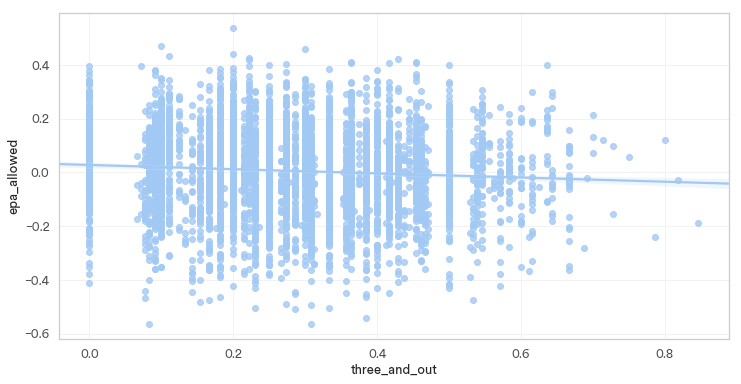

In [205]:
f, ax = plt.subplots(figsize=(12, 6))

ax = sns.regplot(x="three_and_out", y="epa_allowed", data=games)